# Домашнее задание 4. Конструирование текстовых признаков из твитов пользователей

## Сбор данных

Первый этап - сбор твитов пользователей. Необходимо подключаться к Twitter API и запрашивать твиты по id пользователя. 
Подключение к API подробно описано в ДЗ 1.

In [1]:
import twitter
import re
import pandas as pd
import json
import codecs
import time
from sklearn.feature_extraction import DictVectorizer


CONSUMER_KEY = ""
CONSUMER_SECRET = ""

ACCESS_TOKEN_KEY = ""
ACCESS_TOKEN_SECRET = ""

api = twitter.Api(consumer_key = CONSUMER_KEY, 
                  consumer_secret = CONSUMER_SECRET, 
                  access_token_key = ACCESS_TOKEN_KEY, 
                  access_token_secret = ACCESS_TOKEN_SECRET)

Для получения твитов пользователя может быть использован метод GetUserTimeline из библиотеки python-twitter. Он позволяет получить не более 200 твитов пользователя. По каждому пользователю достаточно собрать 200 твитов.

Метод имеет ограничение по количеству запросов в секунду. Для получения информации о промежутке времени, которое необходимо подождать для повторного обращения к API может быть использован метод `GetSleepTime`. Для получения информации об ограничениях запросов с помощью метода `GetUserTimeLine` необходимо вызывать `GetSleepTime` с параметром "statuses/user_timeline".

Метод GetUserTimeline возвращает объекты типа Status. У этих объектов есть метод AsDict, который позволяет представить твит в виде словаря.

Id пользователей необходимо считать из файла, как было сделано в ДЗ 1.

Необходимо реализовать функцию `get_user_tweets(user_id)`. Входной параметр - id пользователя из файла. Возвращаемое значение - массив твитов пользователя, где каждый твит представлен в виде словаря. Предполагается, что информация о пользователе содержится в твитах, которые пользователь написал сам. Это означает, что можно попробовать отфильтровать ответы другим пользователям, ссылки и ретвиты, а так же картинки и видео, так как наша цель - найти текстовую информацию.

In [2]:
#Match strings which start with TGIF or http
pattern = re.compile(u'^((TGIF)|(http)).*')
del_pattern = re.compile(r'(https?:\/\/)?([\w\.]+)\.([a-z]{2,6}\.?)(\/[\w\.]*)*\/?$')
def get_user_tweets(user_id):
    """returns list of tweets as dicts"""
    statuses = api.GetUserTimeline(user_id, count = 200, trim_user = True, exclude_replies = True, include_rts = False)
    statuses = map(lambda x: x.AsDict(), statuses)
    #deleting tweets which start with TGIF or http
    for i in reversed(xrange(len(statuses))):
        if (re.match(pattern, statuses[i]["text"]) != None):
            del statuses[i]
        else:
            #Delete https links in the end of the string
            statuses[i]["text"] = re.sub(del_pattern, "", statuses[i]["text"])
    return statuses
    

In [3]:
#Reading users id
TRAINING_SET_PATH = "train.csv"
TESTING_SET_PATH = "test.csv"
df_users_train = pd.read_csv(TRAINING_SET_PATH, sep=",", header=0)
df_users_ex = pd.read_csv(TESTING_SET_PATH, sep=",", header=0)
df_users_ex['cls'] = None
df_users = pd.concat([df_users_train, df_users_ex])


In [4]:
from os import listdir
from os.path import isfile, join

processed_users = [f for f in listdir("tweets") if isfile(join("tweets", f))]
print len(processed_users)

11165


In [163]:
count_d = 0
count_ex = 0
count_unauth = 0
count_not_ex = 0
for uid in df_users["uid"]:
    try:
        if str(uid) not in processed_users:
            count_d += 1
            tweet = get_user_tweets(uid)
            with codecs.open(u'tweets/' + str(uid), u'w', u'utf-8') as f:
                json.dump(tweet, f)
            if (count_d % 500 == 0):
                print count_d, "downloaded"
        else:
            count_ex += 1
    except twitter.TwitterError as e:
        if e.message == u'Not authorized.':
            count_unauth += 1
        elif e.message == [{u'message': u'Sorry, that page does not exist.', u'code': 34}]:
            count_not_ex += 1
        else:
            print "wait 16 minuts"
            time.sleep(960)
        continue
print u"Not authorized: ", count_unauth
print u"Page does not exist: ", count_not_ex
print u"Previous Downloads: :", count_ex
print u"have been downloaded within this session: ", count_d


Not authorized:  322
Page does not exist:  460
Previous Downloads: : 11147
have been downloaded within this session:  800


## Разбор текста твита

Обработка текста предполагает разбиение текста на отдельные элементы - параграфы, предложения, слова. Мы будем преобразовывать текст твита к словам. Для этого текст необходимо разбить на слова. Сделать это можно, например, с помощью регулярного выражения.

Необходимо реализовать функцию, `get_words(text)`. Входной параметр - строка с текстом. Возвращаемое значение - массив строк (слов). Обратите внимание, что нужно учесть возможное наличие пунктуации и выделить по возможности только слова. 

In [5]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')

def get_words(text):
    """returns list of words"""
    # your code here
    return tokenizer.tokenize(text)

In [165]:
print get_words("Here are different words!")

['Here', 'are', 'different', 'words']


Далее полученные слова необходимо привести к нормальной форме. То есть привести их к форме единственного числа настоящего времени и пр. Сделать это можно с помощью библиотеки nltk. Информацию по загрузке, установке библиотеки и примерах использования можно найти на сайте http://www.nltk.org/

Для загрузки всех необходимых словарей можно воспользоваться методом download из библиотеки nltk.

In [6]:
import nltk
# nltk.download()
wnl = nltk.stem.WordNetLemmatizer()
stopwords_list = nltk.corpus.stopwords.words()

Для дальнейшей обработки слова должны быть приведены к нижнему регистру. 

Для приведения к нормальной форме можно использовать `WordNetLemmatizer` из библиотеки nltk. У этого класса есть метод `lemmatize`.

Также необходимо убрать из текста так называемые стоп-слова. Это часто используемые слова, не несущие смысловой нагрузки для наших задач. Сделать это можно с помощью `stopwords` из nltk.corpus

Необходимо реализовать функцию `get_tokens(words)`. Входной параметр - массив слов. Возвращаемое значение - массив токенов.

In [7]:
def get_tokens(words):
    """returns list of tokens"""
    # your code here
    tokens_list = map(lambda word: wnl.lemmatize(word), words) 
    tokens_list = [word for word in tokens_list if word not in stopwords_list]
    return tokens_list

In [168]:
print get_tokens(["here", "are", "different", "words"])

['different', u'word']


Необходимо реализовать функцию `get_tweet_tokens(tweet)`. Входной параметр - текст твита. Возвращаемое значение -- токены твита. 

In [8]:
def get_tweet_tokens(tweet):
    # your code here
    return get_tokens(get_words(tweet))

Необходимо реализовать функцию `collect_users_tokens()`. Функция должна сконструировать матрицу признаков пользователей. В этой матрице строка - пользователь. Столбец - токен. На пересечении - сколько раз токен встречается у пользователя.
Для построения матрицы можно использовать `DictVectorizer` из `sklearn.feature_extraction`.

In [9]:
def collect_users_tokens(df_users):
    """returns users list and list of user dicts. Each dict contains frequence of user tokens"""
    # your code here
    # save intermediate result
    users_list = []
    tokens_list = []
    stop_words = [u"co", u"I", u"via", u"YouTube", u"The", u"http", u"You", u"video", u"A", u"amp", "This", u"What"]
    count = 0;
    for uid in df_users.uid:
        count += 1
        if (count % 1000 == 0):
            print u" Processed:", count
        user_tweets = []
        if str(uid) in processed_users:
            with codecs.open(u'tweets/' + str(uid), u'r', u'utf-8') as f:
                user_tweets = json.loads(f.readline())
        tokens_dict = {}
        for tweet in user_tweets:
            tokens = get_tweet_tokens(tweet["text"])
            for token in tokens:
                if token in tokens_dict:
                    tokens_dict[token] += 1
                else:
                    if token not in stop_words and len(token) > 2:
                        tokens_dict[token] = 1
        users_list.append(uid)
        tokens_list.append(tokens_dict)
    return users_list, tokens_list


In [10]:
#import pandas as pd
#from collections import defaultdict
#import json
#from sklearn.feature_extraction import DictVectorizer


#TRAINING_SET_URL = "twitter_train.txt"
#EXAMPLE_SET_URL = "twitter_example.txt"
#df_users_train = pd.read_csv(TRAINING_SET_URL, sep=",", header=0, names=["uid", "cat"])
#df_users_ex = pd.read_csv(EXAMPLE_SET_URL, sep=",", header=0, names=["uid", "cat"])
#df_users_ex['cat'] = None
#df_users = pd.concat([df_users_train, df_users_ex])

users, users_tokens = collect_users_tokens(df_users)

 Processed: 1000
 Processed: 2000
 Processed: 3000
 Processed: 4000
 Processed: 5000
 Processed: 6000
 Processed: 7000
 Processed: 8000
 Processed: 9000
 Processed: 10000
 Processed: 11000


In [12]:
import numpy as np
from wordcloud import WordCloud
from PIL import Image
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [15]:
np.savez("files/out_4.dat", data=vs, users=users, users_tokens=users_tokens )

In [15]:
with np.load("files/out_4.dat.npz") as data:
    users_tokens = data["users_tokens"]

In [14]:
v = DictVectorizer()
vs = v.fit_transform(users_tokens)

In [16]:
freq_list = vs.sum(axis = 0)
freq_list = freq_list.tolist()[0]
tokens_freq = zip(v.get_feature_names(), freq_list)

Далее для получения представления о полученной информацию о токенах предлагается отобразить ее в виде облака тэгов. [Подсказка](http://anokhin.github.io/img/tag_cloud.png). 

In [17]:
def draw_tag_cloud(v, vs):
    """Draws tag cloud of found tokens"""
    mask = np.array(Image.open("files/logo.jpg"))
    word_cloud = WordCloud(background_color="white", max_words=500, mask=mask)
    word_cloud.fit_words(tokens_freq)
    word_cloud.to_file("files/result.png")
    plt.figure(figsize = (10, 10))
    plt.imshow(word_cloud)
    plt.axis("off")
    plt.show()
    return

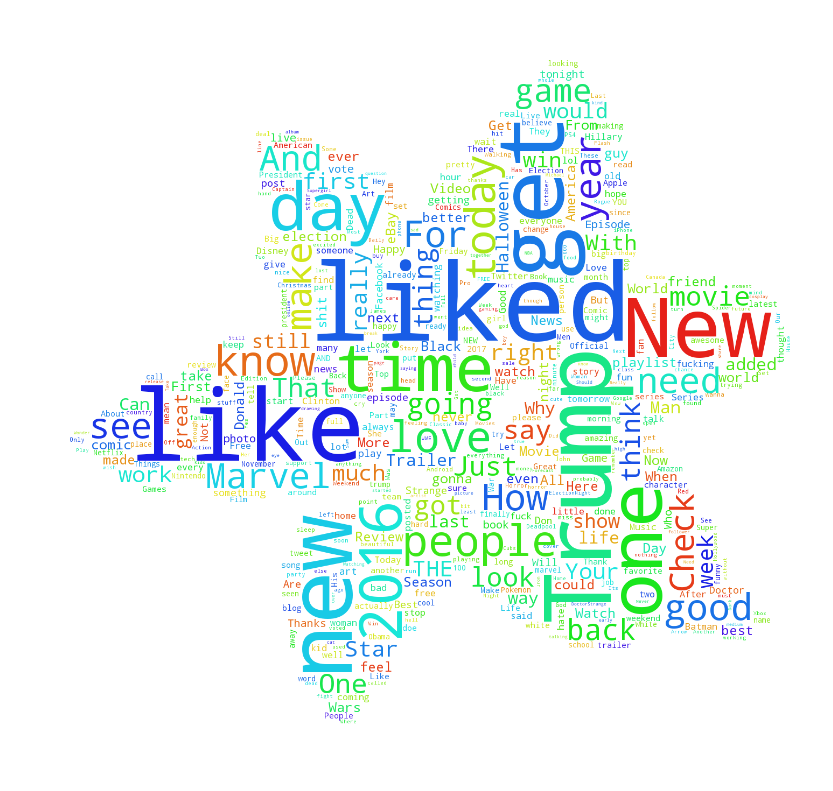

In [18]:
draw_tag_cloud(v, vs)